In [1]:
import math
import time
import os
import urllib2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#from slim.datasets import dataset_utils
#from slim.datasets import flowers
#from slim.datasets import imagenet
from slim.nets import inception
from slim.preprocessing import inception_preprocessing

# Main slim library
from tensorflow.contrib import slim

## Flower dataset

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


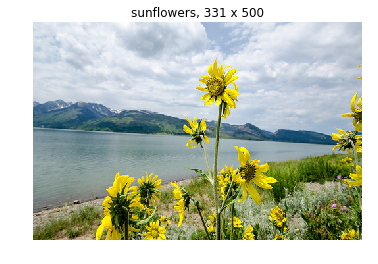

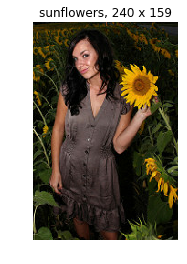

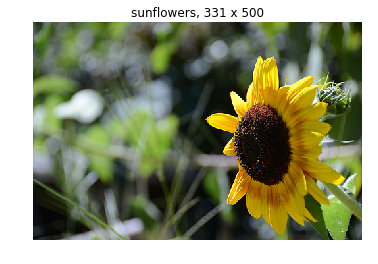

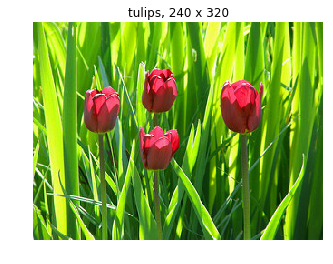

In [3]:
# Located in '/private/tmp/flowers/flowers.tar.gz'
url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

## Inception

* White padding to not distort the images

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


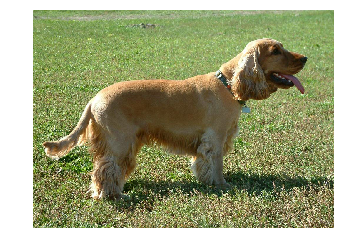

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [5]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        tmp = probabilities
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

## First model with tf.slim

In [28]:
def regression_model(inputs, is_training=True, scope='deep_regression'):
    end_points = {}
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        with slim.arg_scope([slim.fully_connected], 
                               activation_fn=tf.nn.relu,
                               weights_regularizer=slim.l2_regularizer(0.01)):
            a1 = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = a1
            a1_drop = slim.dropout(a1, 0.8, is_training=is_training)
            a2 = slim.fully_connected(a1_drop, 16, scope='fc2')
            end_points['fc2'] = a2
            predictions = slim.fully_connected(a2, 1, activation_fn=None, scope='predictions')
            end_points['predictions'] = predictions
            
    return predictions, end_points

In [30]:
with tf.Graph().as_default():
    inputs = tf.placeholder(tf.float32, shape=[None, 1])
    outputs = tf.placeholder(tf.float32, shape=[None, 1])
    
    predictions, end_points = regression_model(inputs)
    
    print('Layers')
    for k, v in end_points.items():
        print('name = {0}, shape = {1}'.format(v.name, v.get_shape()))
    
    print('\n')
    print('Parameters')
    for v in slim.get_model_variables():
        print('name = {0}, shape = {1}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/predictions/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/predictions/weights:0, shape = (16, 1)
name = deep_regression/predictions/biases:0, shape = (1,)


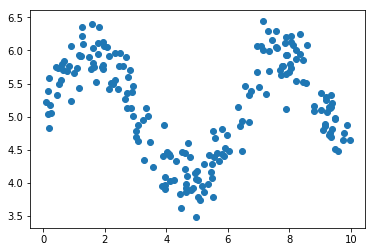

In [27]:
def produce_batch(batch_size, noise=0.3):
    x = np.random.random([batch_size, 1]) * 10
    y = np.sin(x) + 5 + np.random.randn(batch_size, 1) * noise
    return x.astype(np.float32), y.astype(np.float32)

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)
plt.show()

In [37]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [35]:
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    inputs, outputs = convert_data_to_tensors(x_train, y_train)
    predictions, nodes = regression_model(inputs)
    loss = tf.losses.mean_squared_error(labels=outputs, predictions=predictions)
    # User loss + regularization loss
    total_loss = slim.losses.get_total_loss()
    
    optimizer = tf.train.AdamOptimizer(0.05)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training inside a session
    final_loss = slim.learning.train(train_op, 
                                     logdir=ckpt_dir,
                                     number_of_steps=5000,
                                     save_summaries_secs=5,
                                     log_every_n_steps=500)
    
print('Finished training. Last batch loss: {0}'.format(final_loss))
print('Checkpoint saved in %s' % ckpt_dir)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 500: loss = 0.3382 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.2343 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.1980 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.1852 (0.00 sec/step)
INFO:tensorflow:global step 2500: loss = 0.2023 (0.00 sec/step)
INFO:tensorflow:global_step/sec: 554.226
INFO:tensorflow:global step 3000: loss = 0.1750 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.1756 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.1625 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.1793 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1830 (0.00 sec/step)
INFO:tensorflow:

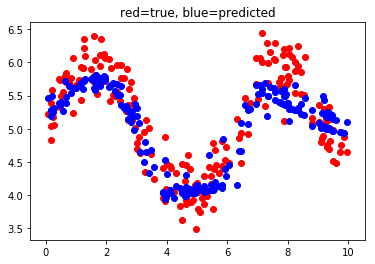

In [40]:
# Load a saved model
with tf.Graph().as_default():
    inputs, outputs = convert_data_to_tensors(x_train, y_train)
    
    predictions, nodes = regression_model(inputs)
    
    # Make a session which restores the parameters from a checkpoint
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, outputs = sess.run([inputs, predictions, outputs])
        
plt.scatter(inputs, outputs, c='r')
plt.scatter(inputs, predictions, c='b')
plt.title('red=true, blue=predicted')
plt.show()

# Fine tune final layer

In [5]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [17]:
image_size = inception.inception_v1.default_image_size

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=2)
        

print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 4: loss = 3.8736 (28.92 sec/step)
INFO:tensorflow:global step 5: loss = 4.1300 (18.92 sec/step)
INFO:tensorflow:global step 6: loss = 2.3270 (18.33 sec/step)
INFO:tensorflow:global step 7: loss = 1.6575 (18.59 sec/step)
INFO:tensorflow:global step 8: loss = 1.9607 (18.59 sec/step)
INFO:tensorflow:global step 9: loss = 1.7902 (18.40 sec/step)
INFO:tensorflow:global step 10: loss = 2.0249 (18.46 sec/step)
INFO:tensorflow:global step 11: loss = 2.2857 (19.75 sec/s

Instructions for updating:
Use `tf.local_variables_initializer` instead.


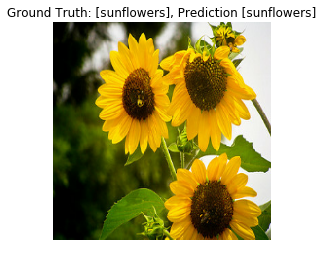

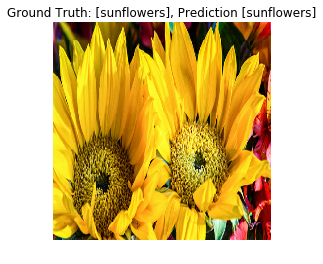

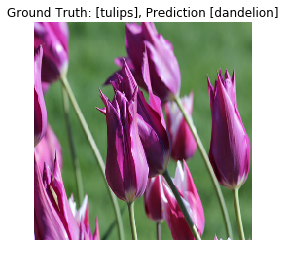

In [18]:
image_size = inception.inception_v1.default_image_size
batch_size = 3
train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

# Downloading images

In [1]:
from datasets.download_images import download_im
dataset_dir = 'data'
download_im('scared', 0, 100, dataset_dir)

# Converting raw data to TFRecord

In [1]:
from datasets.convert_images_tfrecords import convert_images
dataset_dir = 'data'
convert_images(dataset_dir)

>> Converting image 98/98 shard 4
>> Converting image 50/50 shard 4

Finished converting the dataset!


# Loading dataset

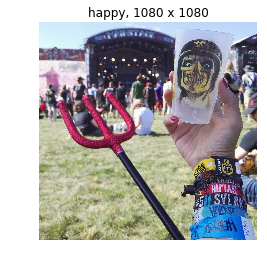

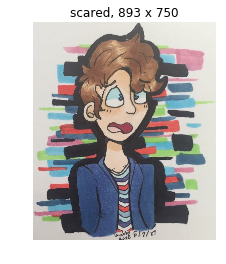

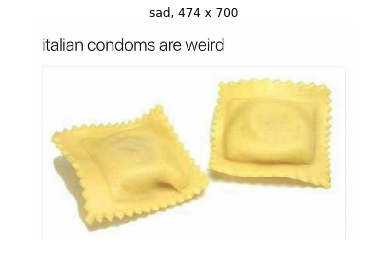

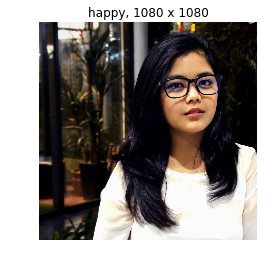

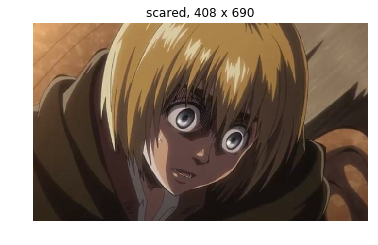

In [2]:
from datasets.convert_to_dataset import get_split
import tensorflow as tf
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
%matplotlib inline

with tf.Graph().as_default(): 
    dataset_dir = 'data'
    dataset = get_split('train', dataset_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(5):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Tune inception model on Tumblr data

In [4]:
from image_model.image_model import download_pretrained_model

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = 'image_model/pretrained_model'
download_pretrained_model(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


In [2]:
#from datasets.convert_to_dataset import get_split
from image_model.image_model import fine_tune_model
dataset_dir = 'data'
checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_model/fine_tuned_model'

fine_tune_model(dataset_dir, checkpoints_dir, train_dir, num_steps=2)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 1.2782 (35.47 sec/step)
INFO:tensorflow:global step 2: loss = 4.0123 (20.83 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 4.012298


# Reuse fine-tuned model

Instructions for updating:
Use `tf.local_variables_initializer` instead.


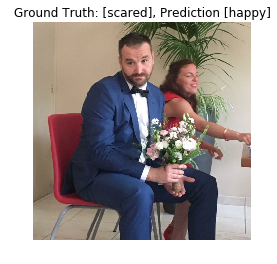

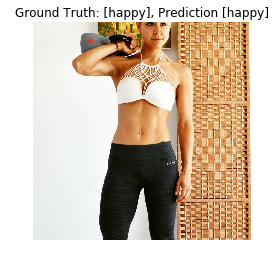

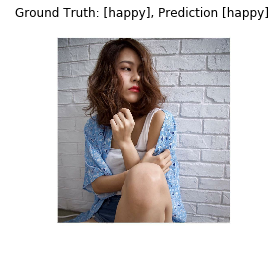

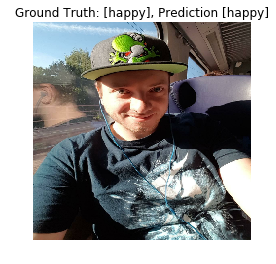

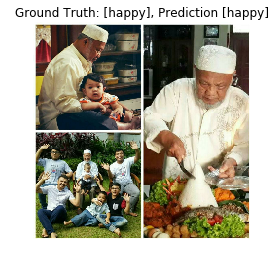

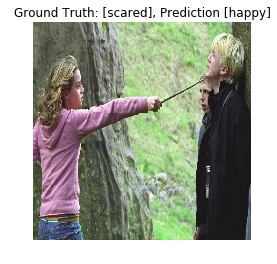

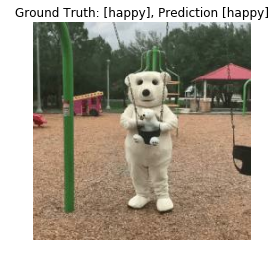

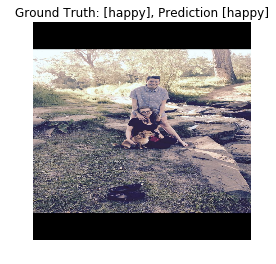

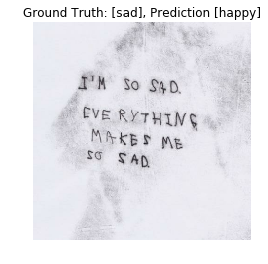

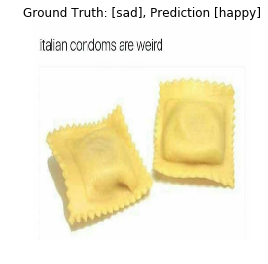

In [7]:
import numpy as np
import tensorflow as tf

from slim.nets import inception
from datasets.convert_to_dataset import get_split
from image_model.image_model import _load_batch
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
%matplotlib inline

image_size = inception.inception_v1.default_image_size
batch_size = 10
dataset_dir = 'data'
train_dir = 'image_model/fine_tuned_model'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('train', dataset_dir)
    images, images_raw, labels = _load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()